In [523]:
import numpy as np
import pandas as pd
from sklearn import linear_model,preprocessing,model_selection
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
  
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [524]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

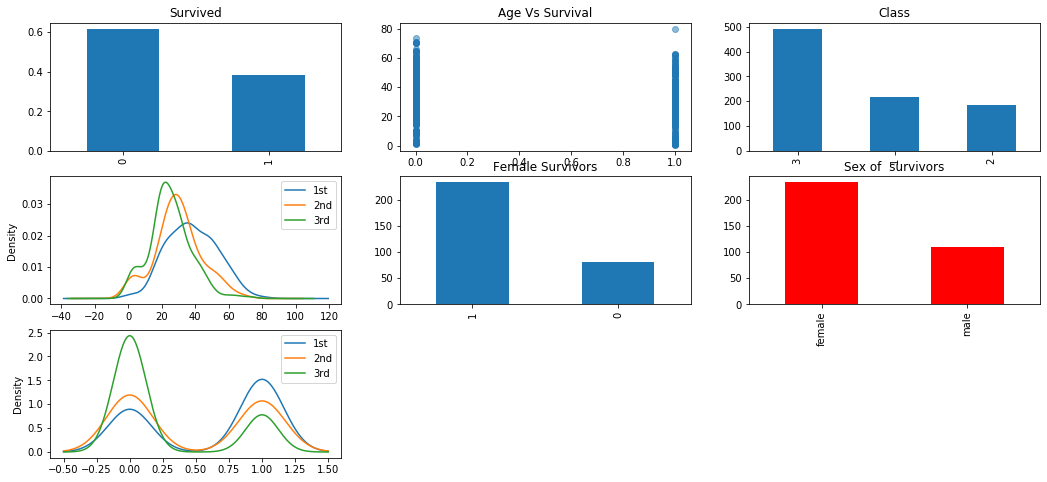

In [525]:
fig=plt.figure(figsize=(24,8))
plt.subplot2grid((3,4),(0,0))

train.Survived.value_counts(normalize=True).plot(kind="bar")
plt.title('Survived')

plt.subplot2grid((3,4),(0,1))
plt.scatter(train.Survived,train.Age,alpha=0.5)
plt.title('Age Vs Survival')

plt.subplot2grid((3,4),(0,2))
train.Pclass.value_counts().plot(kind="bar")
plt.title('Class')

plt.subplot2grid((3,4),(1,0))
for x in [1,2,3]:
    train.Age[train.Pclass == x].plot(kind='kde')
plt.legend(("1st","2nd","3rd"))


plt.subplot2grid((3,4),(1,1))
train.Survived[train.Sex=="female"].value_counts().plot(kind="bar")
plt.title('Female Survivors')

plt.subplot2grid((3,4),(1,2))
train.Sex[train.Survived==1].value_counts().plot(kind="bar", color=['r'])
plt.title('Sex of  survivors')



plt.subplot2grid((3,4),(2,0))
for x in [1,2,3]:
    train.Survived[train.Pclass == x].plot(kind='kde')
plt.legend(("1st","2nd","3rd"))

plt.show()

In [526]:
#Data Clensing 

def fillNullWithMedian(df,col):
    df[col] = df[col].fillna(df[col].dropna().median())

def clean_data(data):
    fillNullWithMedian(data,'Fare')
    fillNullWithMedian(data,'Age')
    data.loc[data['Sex']=='male',"Sex"] = 1
    data.loc[data['Sex']=='female',"Sex"] = 0
    
    data["Embarked"] = data["Embarked"].fillna("S")
    data.loc[data["Embarked"]=="S","Embarked"]= 0
    data.loc[data["Embarked"]=="C","Embarked"]= 1
    data.loc[data["Embarked"]=="Q","Embarked"]= 2 
    return data

def generateVIF(X_tr):
    df = pd.DataFrame()
    df['Features'] = X_tr.columns
    df['VIF'] = [variance_inflation_factor(X_tr.values, i) for i in range(X_tr.shape[1])]
    df = df.sort_values(by = "VIF", ascending = False)
    return(df)

def write_prediction(prediction, name):
    PassengerId = np.array(test["PassengerId"]).astype(int)
    solution = pd.DataFrame(prediction, PassengerId, columns = ["Survived"])
    solution.to_csv(name, index_label = ["PassengerId"])
    

In [534]:
train["hyp"] = 0
train.loc[train.Sex=="female","hyp"]=1

train["result"] = 0
train.loc[train.Survived == train["hyp"], "result"]=1 
train["result"].value_counts(normalize=True)
train = clean_data(train)
test = clean_data(test)
test.shape


(418, 11)

In [535]:
target = train['Survived'].values
features = train[['Pclass','Sex', 'Age','SibSp','Parch','Fare','Embarked']].values
test_features = test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values


In [536]:
 
classifier = linear_model.LinearRegression()
classifier_ = classifier.fit(features,target)
classifier_.score(features,target)

0.39720293461573963

In [537]:
poly = preprocessing.PolynomialFeatures(degree=2)
poly_features = poly.fit_transform(features)

clf = linear_model.LogisticRegression(C=10)
clf.fit(poly_features, target)
print(clf.score(poly_features, target))


0.8338945005611672


In [538]:
decision_tree = tree.DecisionTreeClassifier(random_state=1,
                                           max_depth = 7,min_samples_split=2)
decision_tree_ = decision_tree.fit(features, target)
decision_tree_.score(features, target)

scores = model_selection.cross_val_score(decision_tree, features, target)

In [539]:
scores
scores.mean()

0.8080808080808081

In [543]:
test_features_ = poly.fit_transform(test_features)
clf.predict(test_features_)
write_prediction(clf.predict(test_features_), "results.csv")